### Imports

In [21]:
# Import GeoPandas and Matplotlib
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import rasterio
import rasterio.plot
import rasterstats


In [3]:
# Read the mining site data
mining_sites = gpd.read_file("data/ipis_cod_mines.geojson")

In [4]:
# print rows and crs info
print(f'Mining Site info:\n --------')
print(mining_sites.head())
print(mining_sites.crs)


Mining Site info:
 --------
  visit_date                                name  n_workers mineral  \
0 2013-03-27                           Mayi-Tatu      150.0    Gold   
1 2013-03-27                             Mabanga      115.0    Gold   
2 2013-03-27                             Molende      130.0    Gold   
3 2013-03-27                          Embouchure      135.0    Gold   
4 2013-03-27  Apumu-Atandele-Jerusalem-Luka Yayo      270.0    Gold   

                   geometry  
0  POINT (29.66033 1.01089)  
1  POINT (29.65862 1.00308)  
2  POINT (29.65629 0.98563)  
3  POINT (29.64494 0.99976)  
4       POINT (29.66 0.956)  
EPSG:4326


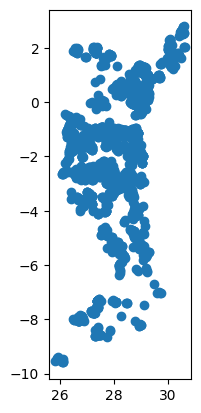

In [5]:
# Make a quick visualisation
mining_sites.plot()
plt.show()

In [6]:
# National Parks Raw Data Preprocessing

part0 = gpd.read_file("data/cod_conservation_shp_0/WDPA_WDOECM_May2025_Public_COD_shp-polygons.shp")
part1 = gpd.read_file("data/cod_conservation_shp_1/WDPA_WDOECM_May2025_Public_COD_shp-polygons.shp")
part2 = gpd.read_file("data/cod_conservation_shp_2/WDPA_WDOECM_May2025_Public_COD_shp-polygons.shp")

# Merge all parts
national_parks = gpd.GeoDataFrame(pd.concat([part0, part1, part2], ignore_index=True))

# Print the first rows and the CRS information
print(national_parks.head())
print(national_parks.crs)



   WDPAID WDPA_PID PA_DEF          NAME     ORIG_NAME          DESIG  \
0  1079.0     1079      1        Upemba        Upemba  Parc National   
1  1080.0     1080      1         Maiko         Maiko  Parc National   
2  1082.0     1082      1  Kahuzi-Biega  Kahuzi-Biega  Parc National   
3  1083.0     1083      1       Garamba       Garamba  Parc National   
4  1084.0     1084      1    Kundelungu    Kundelungu  Parc National   

       DESIG_ENG DESIG_TYPE IUCN_CAT        INT_CRIT  ...  \
0  National Park   National       II  Not Applicable  ...   
1  National Park   National       II  Not Applicable  ...   
2  National Park   National       II  Not Applicable  ...   
3  National Park   National       II  Not Applicable  ...   
4  National Park   National       II  Not Applicable  ...   

                                           MANG_AUTH     MANG_PLAN  \
0  Institut Congolais pour la Conservation de la ...  Not Reported   
1  Institut Congolais pour la Conservation de la ...  Not Re

In [7]:
# Convert both datasets to UTM projection for distance calculations
mining_sites_utm = mining_sites.to_crs(epsg=32735)
national_parks_utm = national_parks.to_crs(epsg=32735)

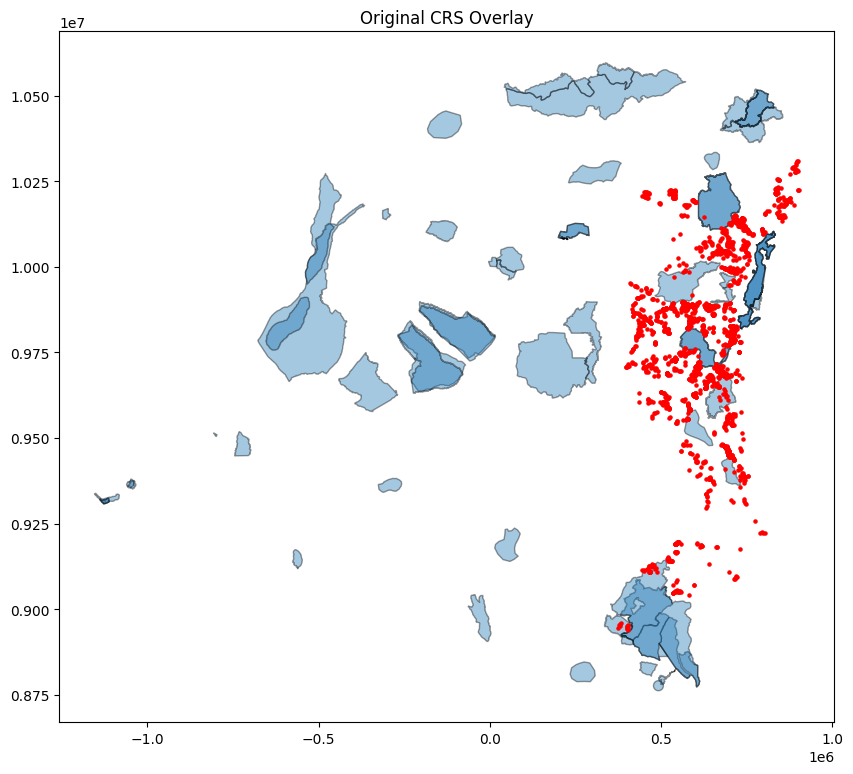

In [8]:
ax = national_parks_utm.plot(figsize=(10, 10), alpha=0.4, edgecolor='black')
mining_sites_utm.plot(ax=ax, color='red', markersize=5)
plt.title("Original CRS Overlay")
plt.show()

### Buffering & Analyzing Goma

In [9]:
# Create Goma point
goma = gpd.GeoSeries([Point(29.22, -1.66)], crs="EPSG:4326")

# Reproject to EPSG:32735
goma_utm = goma.to_crs(epsg=32735)
print(type(goma_utm))

# Buffer 50km in meters
goma_buffer = goma_utm.buffer(50000)

print(goma_buffer.crs)
print(goma_buffer.geometry)

<class 'geopandas.geoseries.GeoSeries'>
EPSG:32735
0    POLYGON ((796989.559 9816380.942, 796748.796 9...
dtype: geometry


In [10]:
print(goma_buffer)

0    POLYGON ((796989.559 9816380.942, 796748.796 9...
dtype: geometry


In [11]:
# masking mining sites to buffer
mask = mining_sites_utm.within(goma_buffer[0])
print(mask.sum())

# Compute intersection geometries
intersections = national_parks_utm.intersection(goma_buffer.iloc[0])
# Compute area of intersections
total_area_km2 = intersections.area.sum() / (1000**2)

print(f"{total_area_km2:.2f} km² of protected land within 50 km of Goma")

87
3894.84 km² of protected land within 50 km of Goma


In [12]:
# Open the vegetation raster (GeoTIFF format)
raster_path = "data/trees_central-africa/trees_central-africa.tif"
src = rasterio.open(raster_path)


In [29]:
vegetation_raster = "data/trees_central-africa/trees_central-africa.tif"
mining_sites['vegetation_code'] = rasterstats.point_query(
    mining_sites.geometry,
    vegetation_raster,
    interpolate='nearest'
)
print(mining_sites.head())


  visit_date                                name  n_workers mineral  \
0 2013-03-27                           Mayi-Tatu      150.0    Gold   
1 2013-03-27                             Mabanga      115.0    Gold   
2 2013-03-27                             Molende      130.0    Gold   
3 2013-03-27                          Embouchure      135.0    Gold   
4 2013-03-27  Apumu-Atandele-Jerusalem-Luka Yayo      270.0    Gold   

                   geometry  vegetation_code  
0  POINT (29.66033 1.01089)                1  
1  POINT (29.65862 1.00308)                1  
2  POINT (29.65629 0.98563)                1  
3  POINT (29.64494 0.99976)                1  
4       POINT (29.66 0.956)                1  


In [33]:
vegetation_types = {
    1: 'Dense moist forest',
    2: 'Secondary forest and rural complex',
    3: 'Forest / savanna mosaic',
    4: 'Dense dry forest and Miombo woodland',
    5: 'Tree savanna and woodland',
    6: 'Grasslands and bare soil',
    7: 'Mangrove',
    8: 'Swamp grasslands',
    9: 'Shrubs and steppe',
    10: 'Continental water bodies',
    11: 'Ocean'
}

mining_sites['vegetation'] = mining_sites['vegetation_code'].replace(vegetation_types)

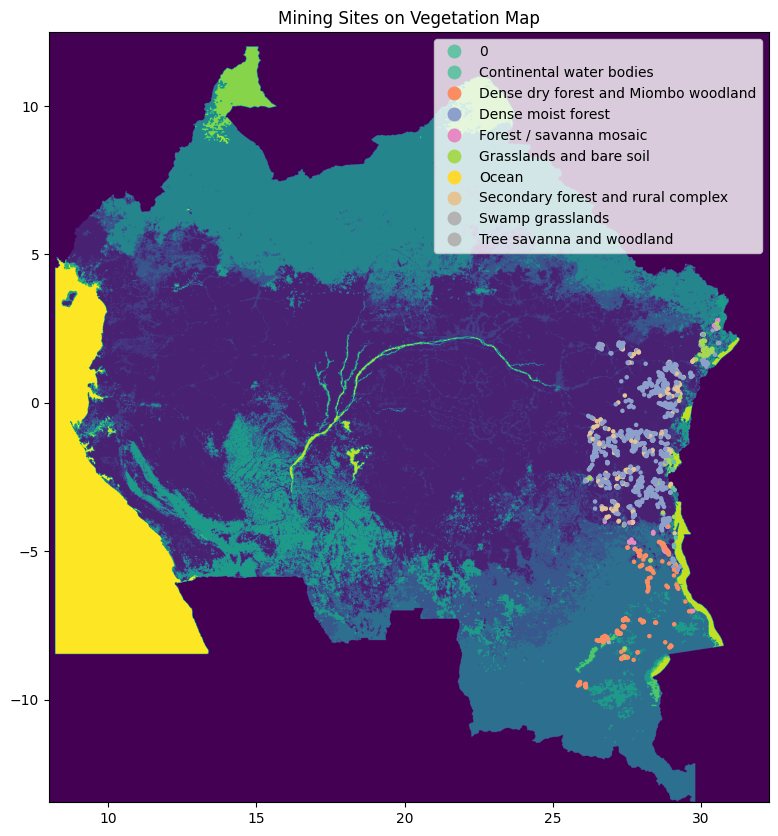

In [34]:
# Show raster background
fig, ax = plt.subplots(figsize=(12, 10))
show(src, ax=ax)

# Plot mining sites on top
mining_sites.plot(ax=ax, column='vegetation', markersize=5, legend=True, cmap='Set2')

plt.title("Mining Sites on Vegetation Map")
plt.show()